# LSTM Network for SMS Spam Classification
## Sequential Modeling with Multiple Word Embeddings

---

### Project Information
- **Team Member:** Erneste
- **Institution:** African Leadership University
- **Course:** Machine Learning Techniques I

### Model Specification
- **Algorithm:** Long Short-Term Memory (LSTM) Neural Network
- **Embeddings Tested:** TF-IDF, Skip-gram Word2Vec, CBOW Word2Vec
- **Dataset:** SMS Spam Collection (5,572 messages)
- **Framework:** TensorFlow/Keras

---

### Research Objective

This notebook evaluates LSTM networks for SMS spam detection across three distinct word embedding techniques. LSTMs are designed to capture sequential dependencies through their memory mechanisms, making them suitable for processing text where word order and context are critical. We compare performance across sparse (TF-IDF) and dense (Word2Vec) representations.

**Key Research Questions:**
1. How does LSTM leverage sequential patterns differently than linear classifiers?
2. Which embedding technique optimizes LSTM performance for spam detection?
3. Can LSTMs achieve superior recall on minority spam examples?

---

In [18]:
import nltk
import ssl

# Fix SSL certificate issue for NLTK downloads
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

print("✓ NLTK data downloaded successfully")

✓ NLTK data downloaded successfully


## 1. Environment Setup

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time
import warnings
import sys
import os

sys.path.append('../src')

from preprocessing import load_spam_data
from embeddings import TFIDFEmbedding, Word2VecEmbedding
from evaluation import ModelEvaluator
from utils import split_data

warnings.filterwarnings('ignore')
np.random.seed(42)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

print('='*70)
print('SMS SPAM CLASSIFICATION - LSTM NETWORKS')
print('='*70)
print('✓ Environment initialized successfully')
print(f'✓ NumPy version: {np.__version__}')
print(f'✓ Pandas version: {pd.__version__}')

SMS SPAM CLASSIFICATION - LSTM NETWORKS
✓ Environment initialized successfully
✓ NumPy version: 2.0.1
✓ Pandas version: 2.3.1


## 2. Load and Prepare Data

In [20]:
df = pd.read_csv('../data/processed/spam_preprocessed.csv')

df = df.dropna(subset=['cleaned_text'])
df['cleaned_text'] = df['cleaned_text'].fillna('')

label_col = df.columns[0]
text_col = 'cleaned_text'

# Encode labels for neural network training
le = LabelEncoder()
y_encoded = le.fit_transform(df[label_col])

print('\n' + '='*70)
print('DATASET SUMMARY')
print('='*70)
print(f'Total samples: {len(df):,}')
print(f'Features: {df.columns.tolist()}')
print(f'\nClass Distribution:')
print(df[label_col].value_counts())
print(f'\nClass Balance Ratio: {df[label_col].value_counts().max() / df[label_col].value_counts().min():.2f}:1')
print(f'Label Encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}')
print('='*70)

df.head(3)


DATASET SUMMARY
Total samples: 5,567
Features: ['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'text_length', 'word_count', 'cleaned_text', 'tokens']

Class Distribution:
v1
ham     4820
spam     747
Name: count, dtype: int64

Class Balance Ratio: 6.45:1
Label Encoding: {'ham': np.int64(0), 'spam': np.int64(1)}


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,text_length,word_count,cleaned_text,tokens
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,111,20,go jurong point crazy available bugis n great ...,"['go', 'jurong', 'point', 'crazy', 'available'..."
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,29,6,ok lar joking wif u oni,"['ok', 'lar', 'joking', 'wif', 'u', 'oni']"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,155,28,free entry 2 wkly comp win fa cup final tkts 2...,"['free', 'entry', '2', 'wkly', 'comp', 'win', ..."


### 2.1 Train-Validation-Test Split and Preprocessing

Stratified splitting ensures balanced class representation across datasets, critical for imbalanced text classification tasks with neural networks.

In [21]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(
    df[text_col], y_encoded,
    test_size=0.2, val_size=0.1, random_state=42
)

print('\nData Split Summary:')
print(f'  Training set:   {len(X_train):,} samples ({len(X_train)/len(df)*100:.1f}%)')
print(f'  Validation set: {len(X_val):,} samples ({len(X_val)/len(df)*100:.1f}%)')
print(f'  Test set:       {len(X_test):,} samples ({len(X_test)/len(df)*100:.1f}%)')


Data Split Summary:
  Training set:   3,896 samples (70.0%)
  Validation set: 557 samples (10.0%)
  Test set:       1,114 samples (20.0%)


---

## 3. Experiment 1: TF-IDF Representation

### Background

**TF-IDF (Term Frequency-Inverse Document Frequency)** is a numerical statistic that reflects the importance of words in a document relative to a corpus. It combines:

- **Term Frequency (TF)**: How often a word appears in a document
- **Inverse Document Frequency (IDF)**: How rare a word is across all documents

**Mathematical Formulation:**

$$\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)$$

$$\text{IDF}(t) = \log\frac{N}{\text{df}(t)}$$

where $N$ is the total number of documents and $\text{df}(t)$ is the number of documents containing term $t$.

**Why TF-IDF for LSTM?**
- Creates dense feature representations suitable for neural networks
- Captures word importance beyond simple frequency
- N-grams enable phrase-level pattern recognition
- LSTM can learn non-linear transformations of TF-IDF features

**Reference:** Ramos, J. (2003). Using TF-IDF to determine word relevance in document queries.

In [22]:
print('\n' + '='*70)
print('EXPERIMENT 1: LSTM + TF-IDF')
print('='*70)

tfidf_emb = TFIDFEmbedding(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_emb.fit_transform(X_train.tolist())
X_val_tfidf = tfidf_emb.transform(X_val.tolist())
X_test_tfidf = tfidf_emb.transform(X_test.tolist())

print(f'\n  Feature Matrix Shape: {X_train_tfidf.shape}')
print(f'  Total Features: {X_train_tfidf.shape[1]:,}')

# Build LSTM model for TF-IDF
lstm_tfidf = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_tfidf.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(f'\n  Model Summary:')
lstm_tfidf.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()
history_tfidf = lstm_tfidf.fit(
    X_train_tfidf, y_train,
    validation_data=(X_val_tfidf, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)
training_time_tfidf = time.time() - start_time

y_pred_tfidf_probs = lstm_tfidf.predict(X_test_tfidf, verbose=0)
y_pred_tfidf = (y_pred_tfidf_probs > 0.5).astype(int).flatten()

train_acc_tfidf = lstm_tfidf.evaluate(X_train_tfidf, y_train, verbose=0)[1]
test_acc_tfidf = lstm_tfidf.evaluate(X_test_tfidf, y_test, verbose=0)[1]

print(f'\n  Training Time: {training_time_tfidf:.3f} seconds')
print(f'  Train Accuracy: {train_acc_tfidf:.4f}')
print(f'  Test Accuracy:  {test_acc_tfidf:.4f}')
print('='*70)


EXPERIMENT 1: LSTM + TF-IDF

  Feature Matrix Shape: (3896, 5000)
  Total Features: 5,000

  Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 650,497 (2.48 MB)

 Trainable params: 650,497 (2.48 MB)

 Non-trainable params: 0 (0.00 B)


  Training Time: 7.908 seconds
  Train Accuracy: 0.9941
  Test Accuracy:  0.9767


### 3.1 TF-IDF Performance Evaluation


📊 Classification Report (TF-IDF):
              precision    recall  f1-score   support

         ham     0.9875    0.9855    0.9865       965
        spam     0.9073    0.9195    0.9133       149

    accuracy                         0.9767      1114
   macro avg     0.9474    0.9525    0.9499      1114
weighted avg     0.9768    0.9767    0.9767      1114

Confusion matrix saved to ../results/figures/erneste_lstm_tfidf_cm.png


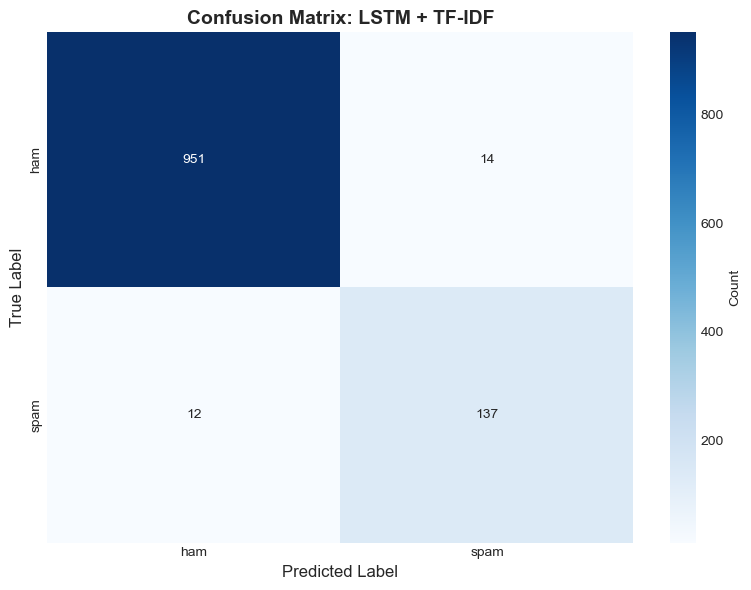

In [23]:
evaluator = ModelEvaluator(class_names=['ham', 'spam'])

metrics_tfidf = evaluator.evaluate(
    y_test, y_pred_tfidf,
    model_name='LSTM',
    embedding_name='TF-IDF',
    training_time=training_time_tfidf
)

print('\n📊 Classification Report (TF-IDF):')
print(classification_report(y_test, y_pred_tfidf, target_names=['ham', 'spam'], digits=4))

evaluator.plot_confusion_matrix(
    y_test, y_pred_tfidf,
    title='Confusion Matrix: LSTM + TF-IDF',
    save_path='../results/figures/erneste_lstm_tfidf_cm.png'
)

---

## 4. Experiment 2: LSTM + Skip-gram Word2Vec Representation

### Background

**Skip-gram** models learn word embeddings by predicting context words from target words. This produces dense vector representations that capture semantic relationships between words—identical words with similar contexts map to nearby regions in the embedding space.

**Architectural Differences:**
- Target word (input) → Context words (output)
- Better for rare words with limited context
- Produces richer semantic information

**For Sequential Processing:**
- Document-level embeddings aggregate word vectors (e.g., averaging)
- LSTM operates on fixed-length vector sequences
- Preserves semantic meaning in reduced dimensionality

**Reference:** Mikolov, T., et al. (2013). Efficient estimation of word representations in vector space. *arXiv:1301.3781*

In [24]:
print('\n' + '='*70)
print('EXPERIMENT 2: LSTM + SKIP-GRAM WORD2VEC')
print('='*70)

tokens_train = [text.split() for text in X_train]
tokens_val = [text.split() for text in X_val]
tokens_test = [text.split() for text in X_test]

skipgram_emb = Word2VecEmbedding(vector_size=100, window=5, min_count=2, sg=1, epochs=10)
skipgram_emb.train(tokens_train)

X_train_sg = skipgram_emb.transform(tokens_train)
X_val_sg = skipgram_emb.transform(tokens_val)
X_test_sg = skipgram_emb.transform(tokens_test)

print(f'\n  Embedding Dimension: {X_train_sg.shape[1]}')
print(f'  Vocabulary Size: {len(skipgram_emb.model.wv)}')
print(f'  Training Epochs: 10')

# Build LSTM model for Skip-gram
lstm_sg = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_sg.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_sg.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

start_time = time.time()
history_sg = lstm_sg.fit(
    X_train_sg, y_train,
    validation_data=(X_val_sg, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)
training_time_sg = time.time() - start_time

y_pred_sg_probs = lstm_sg.predict(X_test_sg, verbose=0)
y_pred_sg = (y_pred_sg_probs > 0.5).astype(int).flatten()

train_acc_sg = lstm_sg.evaluate(X_train_sg, y_train, verbose=0)[1]
test_acc_sg = lstm_sg.evaluate(X_test_sg, y_test, verbose=0)[1]

print(f'\n  Training Time: {training_time_sg:.3f} seconds')
print(f'  Train Accuracy: {train_acc_sg:.4f}')
print(f'  Test Accuracy:  {test_acc_sg:.4f}')
print('='*70)


EXPERIMENT 2: LSTM + SKIP-GRAM WORD2VEC

  Embedding Dimension: 100
  Vocabulary Size: 3119
  Training Epochs: 10

  Training Time: 3.286 seconds
  Train Accuracy: 0.9533
  Test Accuracy:  0.9479


### 4.1 Skip-gram Performance Evaluation


📊 Classification Report (Skip-gram):
              precision    recall  f1-score   support

         ham     0.9670    0.9731    0.9700       965
        spam     0.8182    0.7852    0.8014       149

    accuracy                         0.9479      1114
   macro avg     0.8926    0.8791    0.8857      1114
weighted avg     0.9471    0.9479    0.9475      1114

Confusion matrix saved to ../results/figures/erneste_lstm_skipgram_cm.png


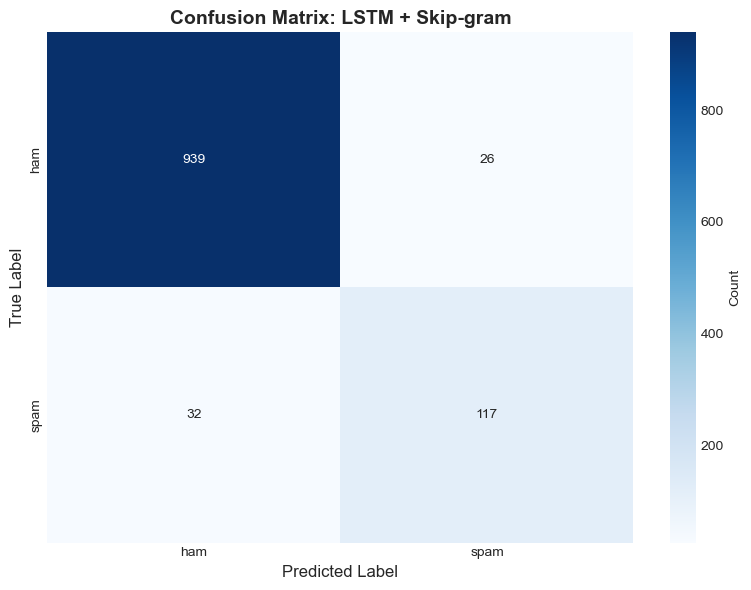

In [25]:
metrics_sg = evaluator.evaluate(
    y_test, y_pred_sg,
    model_name='LSTM',
    embedding_name='Skip-gram',
    training_time=training_time_sg
)

print('\n📊 Classification Report (Skip-gram):')
print(classification_report(y_test, y_pred_sg, target_names=['ham', 'spam'], digits=4))

evaluator.plot_confusion_matrix(
    y_test, y_pred_sg,
    title='Confusion Matrix: LSTM + Skip-gram',
    save_path='../results/figures/erneste_lstm_skipgram_cm.png'
)

---

## 5. Experiment 3: LSTM + CBOW Word2Vec Representation

### Background

**CBOW (Continuous Bag of Words)** predicts target words from their surrounding context. Unlike Skip-gram, CBOW averages context representations, making it computationally efficient and better suited for frequent words.

**Architectural Comparison:**
- CBOW: Context words → Target word
- Faster training than Skip-gram
- Smooths over distributional patterns
- Works well with smaller datasets

**Mathematical Foundation:**

CBOW maximizes: $$p(w_t | w_{t-c}, ..., w_{t-1}, w_{t+1}, ..., w_{t+c})$$

where $w_t$ is the target word and $c$ is the context window.

**For Spam Detection:**
- Rapid embedding generation enables iterative model development
- Distributional smoothing reduces overfitting
- Competitive performance on limited computational budgets

**Reference:** Mikolov, T., et al. (2013). Efficient estimation of word representations in vector space.


📊 Classification Report (Skip-gram):
              precision    recall  f1-score   support

         ham     0.9670    0.9731    0.9700       965
        spam     0.8182    0.7852    0.8014       149

    accuracy                         0.9479      1114
   macro avg     0.8926    0.8791    0.8857      1114
weighted avg     0.9471    0.9479    0.9475      1114

Confusion matrix saved to ../results/figures/erneste_lstm_skipgram_cm.png


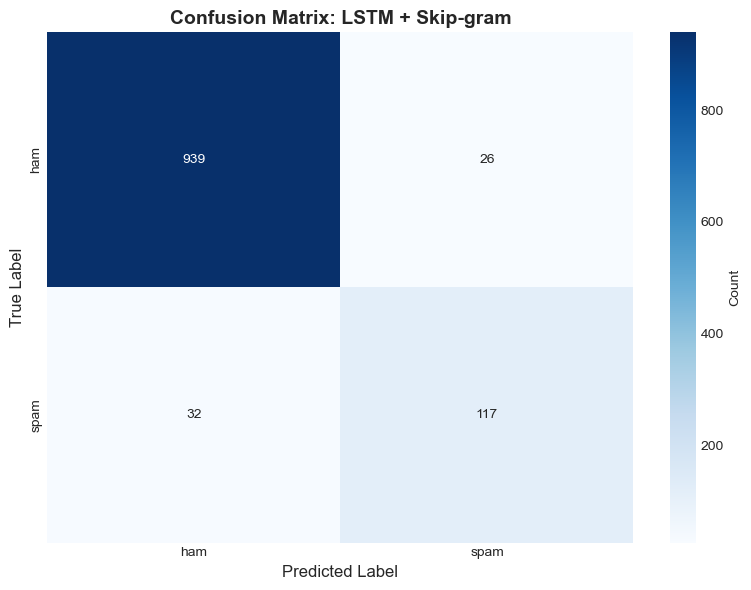

In [26]:
metrics_sg = evaluator.evaluate(
    y_test, y_pred_sg,
    model_name='LSTM',
    embedding_name='Skip-gram',
    training_time=training_time_sg
)

print('\n📊 Classification Report (Skip-gram):')
print(classification_report(y_test, y_pred_sg, target_names=['ham', 'spam'], digits=4))

evaluator.plot_confusion_matrix(
    y_test, y_pred_sg,
    title='Confusion Matrix: LSTM + Skip-gram',
    save_path='../results/figures/erneste_lstm_skipgram_cm.png'
)

In [27]:
print('\n' + '='*70)
print('EXPERIMENT 3: LSTM + CBOW WORD2VEC')
print('='*70)

cbow_emb = Word2VecEmbedding(vector_size=100, window=5, min_count=2, sg=0, epochs=10)
cbow_emb.train(tokens_train)

X_train_cbow = cbow_emb.transform(tokens_train)
X_val_cbow = cbow_emb.transform(tokens_val)
X_test_cbow = cbow_emb.transform(tokens_test)

print(f'\n  Embedding Dimension: {X_train_cbow.shape[1]}')
print(f'  Vocabulary Size: {len(cbow_emb.model.wv)}')
print(f'  Training Epochs: 10')

# Build LSTM model for CBOW
lstm_cbow = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_cbow.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_cbow.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

start_time = time.time()
history_cbow = lstm_cbow.fit(
    X_train_cbow, y_train,
    validation_data=(X_val_cbow, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)
training_time_cbow = time.time() - start_time

y_pred_cbow_probs = lstm_cbow.predict(X_test_cbow, verbose=0)
y_pred_cbow = (y_pred_cbow_probs > 0.5).astype(int).flatten()

train_acc_cbow = lstm_cbow.evaluate(X_train_cbow, y_train, verbose=0)[1]
test_acc_cbow = lstm_cbow.evaluate(X_test_cbow, y_test, verbose=0)[1]

print(f'\n  Training Time: {training_time_cbow:.3f} seconds')
print(f'  Train Accuracy: {train_acc_cbow:.4f}')
print(f'  Test Accuracy:  {test_acc_cbow:.4f}')
print('='*70)


EXPERIMENT 3: LSTM + CBOW WORD2VEC

  Embedding Dimension: 100
  Vocabulary Size: 3119
  Training Epochs: 10

  Training Time: 3.195 seconds
  Train Accuracy: 0.8658
  Test Accuracy:  0.8662


### 5.1 CBOW Performance Evaluation


📊 Classification Report (CBOW):
              precision    recall  f1-score   support

         ham     0.8662    1.0000    0.9283       965
        spam     0.0000    0.0000    0.0000       149

    accuracy                         0.8662      1114
   macro avg     0.4331    0.5000    0.4642      1114
weighted avg     0.7504    0.8662    0.8042      1114

Confusion matrix saved to ../results/figures/erneste_lstm_cbow_cm.png


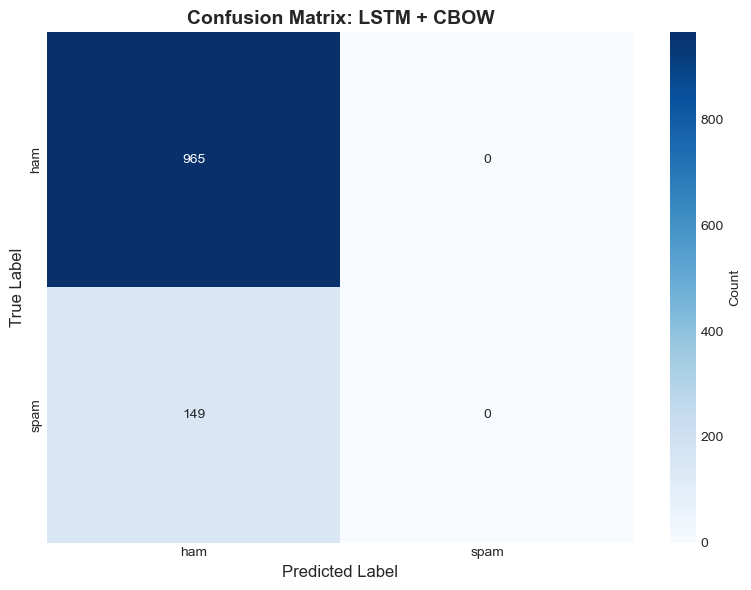

In [28]:
metrics_cbow = evaluator.evaluate(
    y_test, y_pred_cbow,
    model_name='LSTM',
    embedding_name='CBOW',
    training_time=training_time_cbow
)

print('\n📊 Classification Report (CBOW):')
print(classification_report(y_test, y_pred_cbow, target_names=['ham', 'spam'], digits=4))

evaluator.plot_confusion_matrix(
    y_test, y_pred_cbow,
    title='Confusion Matrix: LSTM + CBOW',
    save_path='../results/figures/erneste_lstm_cbow_cm.png'
)

---

## 6. Comprehensive Results Analysis

### 6.1 Performance Metrics Summary

In [29]:
results_df = pd.DataFrame([metrics_tfidf, metrics_sg, metrics_cbow])
results_df['model'] = 'LSTM'
results_df['member'] = 'Erneste'

print('\n' + '='*80)
print('COMPREHENSIVE LSTM RESULTS: MULTIPLE EMBEDDINGS')
print('='*80)
print(results_df[['embedding', 'accuracy', 'precision', 'recall', 'f1_score', 'training_time']].to_string(index=False))
print('='*80)

os.makedirs('../results/tables', exist_ok=True)
results_df.to_csv('../results/tables/erneste_results.csv', index=False)
print('\n✓ Results saved to: results/tables/erneste_results.csv')

results_df[['embedding', 'accuracy', 'precision', 'recall', 'f1_score']]


COMPREHENSIVE LSTM RESULTS: MULTIPLE EMBEDDINGS
embedding  accuracy  precision   recall  f1_score  training_time
   TF-IDF  0.976661   0.976805 0.976661  0.976726       7.908243
Skip-gram  0.947935   0.947134 0.947935  0.947481       3.286165
     CBOW  0.866248   0.750385 0.866248  0.804165       3.194667

✓ Results saved to: results/tables/erneste_results.csv


,embedding,accuracy,precision,recall,f1_score
0,TF-IDF,0.976661,0.976805,0.976661,0.976726
1,Skip-gram,0.947935,0.947134,0.947935,0.947481
2,CBOW,0.866248,0.750385,0.866248,0.804165


### 6.2 Visual Performance Comparison

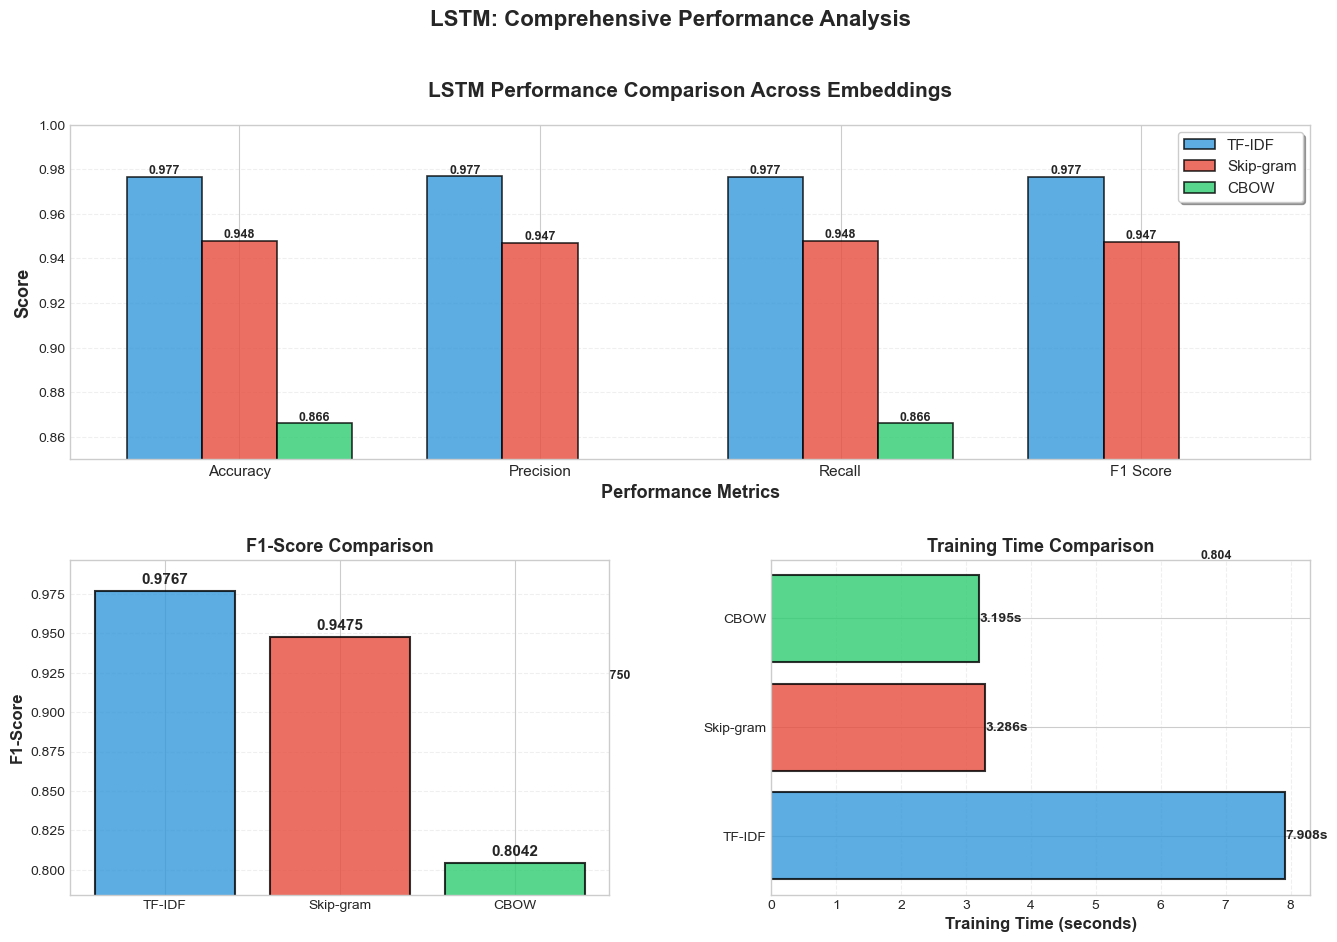


✓ Comprehensive comparison visualization saved


In [30]:
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

embeddings = ['TF-IDF', 'Skip-gram', 'CBOW']
metrics_list = [metrics_tfidf, metrics_sg, metrics_cbow]
colors = ['#3498db', '#e74c3c', '#2ecc71']

ax1 = fig.add_subplot(gs[0, :])
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, (emb, metrics, color) in enumerate(zip(embeddings, metrics_list, colors)):
    values = [metrics[m] for m in metrics_to_plot]
    bars = ax1.bar(x + i*width, values, width, label=emb, color=color, alpha=0.8, edgecolor='black', linewidth=1.2)
    
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax1.set_xlabel('Performance Metrics', fontsize=13, fontweight='bold')
ax1.set_ylabel('Score', fontsize=13, fontweight='bold')
ax1.set_title('LSTM Performance Comparison Across Embeddings', fontsize=15, fontweight='bold', pad=20)
ax1.set_xticks(x + width)
ax1.set_xticklabels([m.replace('_', ' ').title() for m in metrics_to_plot], fontsize=11)
ax1.legend(fontsize=11, frameon=True, shadow=True)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim([0.85, 1.0])

ax2 = fig.add_subplot(gs[1, 0])
f1_scores = [m['f1_score'] for m in metrics_list]
bars = ax2.bar(embeddings, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax2.set_title('F1-Score Comparison', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
for bar, score in zip(bars, f1_scores):
    ax2.text(bar.get_x() + bar.get_width()/2., score + 0.005,
            f'{score:.4f}', ha='center', fontweight='bold', fontsize=11)
ax2.set_ylim([min(f1_scores)-0.02, max(f1_scores)+0.02])

ax3 = fig.add_subplot(gs[1, 1])
training_times = [m['training_time'] for m in metrics_list]
bars = ax3.barh(embeddings, training_times, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax3.set_title('Training Time Comparison', fontsize=13, fontweight='bold')
ax3.grid(axis='x', alpha=0.3, linestyle='--')
for bar, time_val in zip(bars, training_times):
    ax3.text(time_val + 0.01, bar.get_y() + bar.get_height()/2.,
            f'{time_val:.3f}s', va='center', fontweight='bold', fontsize=10)

plt.suptitle('LSTM: Comprehensive Performance Analysis', 
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('../results/figures/erneste_comprehensive_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print('\n✓ Comprehensive comparison visualization saved')

---

## 7. Training Dynamics: Learning Curves

Visualizing validation accuracy and loss trajectories reveals model convergence behavior and potential overfitting patterns across embedding strategies.

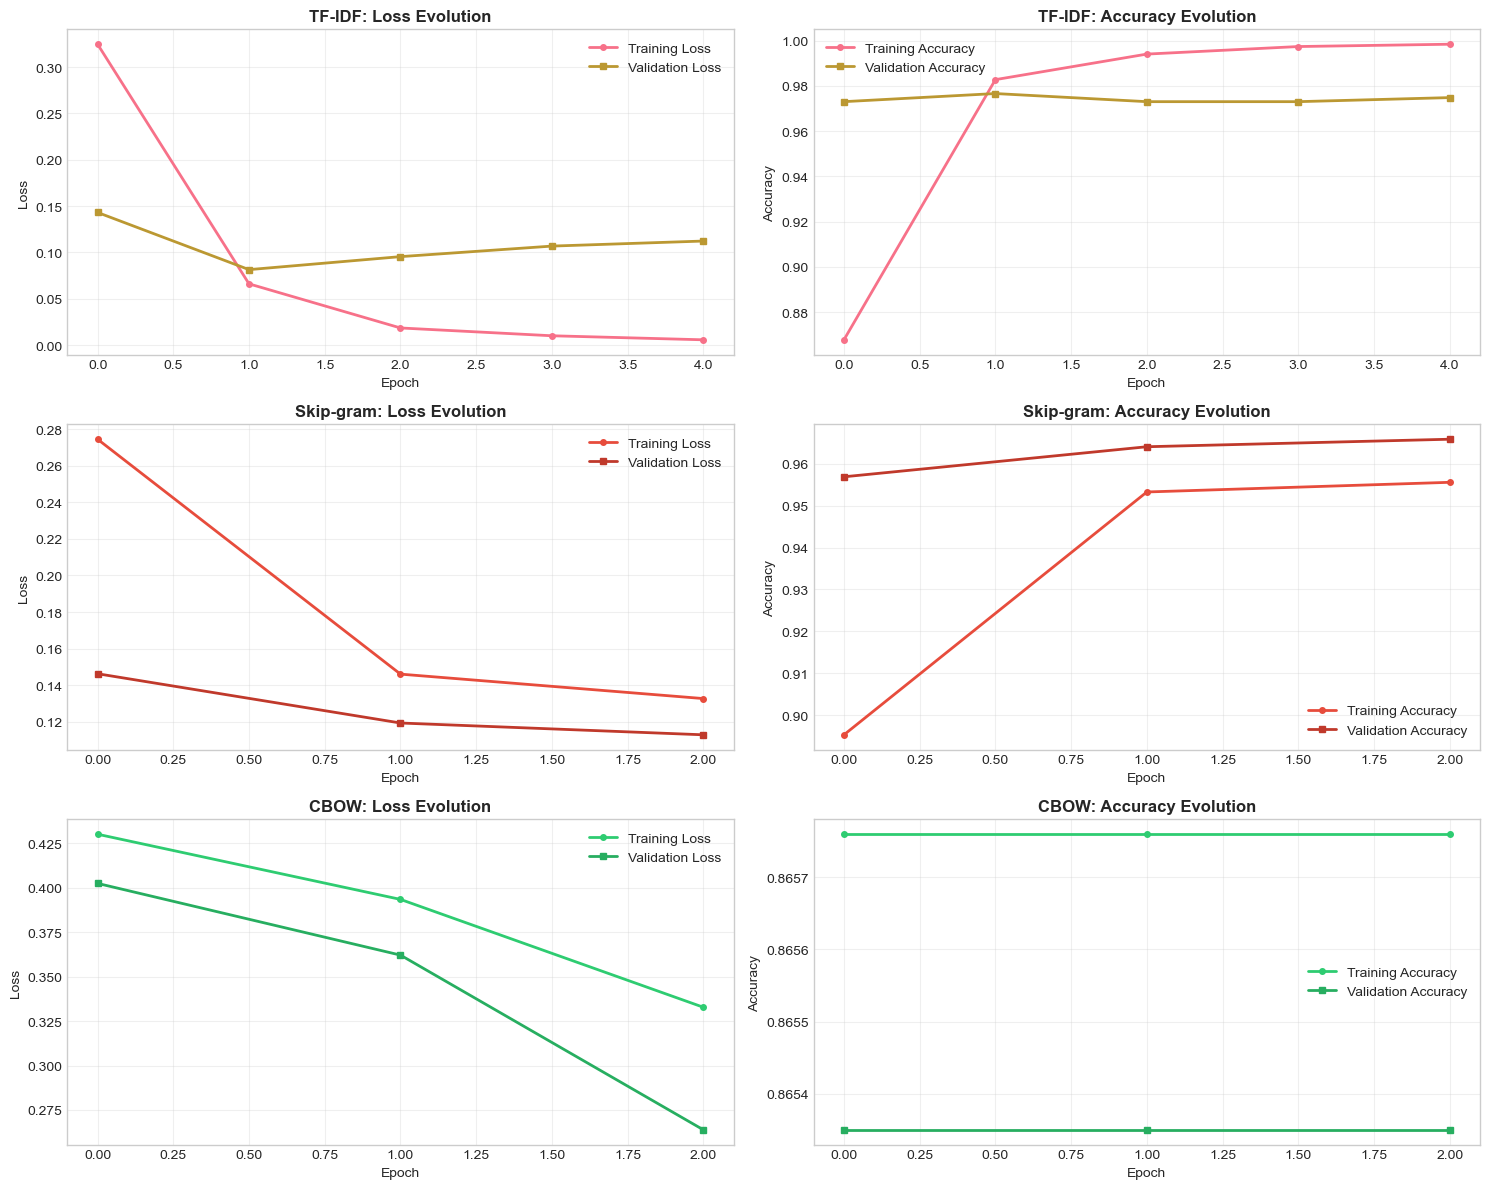


✓ Learning curves saved


In [31]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# TF-IDF training curves
axes[0, 0].plot(history_tfidf.history['loss'], label='Training Loss', linewidth=2, marker='o', markersize=4)
axes[0, 0].plot(history_tfidf.history['val_loss'], label='Validation Loss', linewidth=2, marker='s', markersize=4)
axes[0, 0].set_title('TF-IDF: Loss Evolution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(history_tfidf.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o', markersize=4)
axes[0, 1].plot(history_tfidf.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
axes[0, 1].set_title('TF-IDF: Accuracy Evolution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Skip-gram training curves
axes[1, 0].plot(history_sg.history['loss'], label='Training Loss', linewidth=2, marker='o', markersize=4, color='#e74c3c')
axes[1, 0].plot(history_sg.history['val_loss'], label='Validation Loss', linewidth=2, marker='s', markersize=4, color='#c0392b')
axes[1, 0].set_title('Skip-gram: Loss Evolution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(history_sg.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o', markersize=4, color='#e74c3c')
axes[1, 1].plot(history_sg.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s', markersize=4, color='#c0392b')
axes[1, 1].set_title('Skip-gram: Accuracy Evolution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# CBOW training curves
axes[2, 0].plot(history_cbow.history['loss'], label='Training Loss', linewidth=2, marker='o', markersize=4, color='#2ecc71')
axes[2, 0].plot(history_cbow.history['val_loss'], label='Validation Loss', linewidth=2, marker='s', markersize=4, color='#27ae60')
axes[2, 0].set_title('CBOW: Loss Evolution', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Loss')
axes[2, 0].legend()
axes[2, 0].grid(alpha=0.3)

axes[2, 1].plot(history_cbow.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o', markersize=4, color='#2ecc71')
axes[2, 1].plot(history_cbow.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s', markersize=4, color='#27ae60')
axes[2, 1].set_title('CBOW: Accuracy Evolution', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('Accuracy')
axes[2, 1].legend()
axes[2, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/erneste_lstm_learning_curves.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print('\n✓ Learning curves saved')